# Price Elasticity of Demand Analysis

Overview:
This script performs a data analysis on the price elasticity of items across different hierarchies, providing insights into how sensitive sales are to price changes at various levels.

Author: Chloe Ang (Ke Er Ang)

In [1]:
import pandas as pd
import statsmodels.api as sm 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import warnings

# Filter out specific warning category
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=pd.errors.DtypeWarning)
pd.set_option('display.max_colwidth', None) 

In [2]:
def ped1(group):
    X = sm.add_constant(group['sell_price'])
    model = sm.OLS(group['sold'], X).fit()
    price_coef = model.params['sell_price']
    mean_sellprice = np.mean(group['sell_price'])
    mean_quantity = np.mean(group['sold'])
    ped = price_coef * (mean_sellprice / mean_quantity)
    return ped

In [272]:
# OLS method
def ped2(group):
    X = sm.add_constant(group['sell_price'])
    model = sm.OLS(group['sold'], X).fit()
    price_coef = model.params['sell_price']
    return price_coef

In [204]:
def ped3(data_df):
    # Calculate the percentage change in quantity demanded
    data_df['percentage_change_quantity'] = data_df['sold'].pct_change() * 100

    # Calculate the percentage change in price
    data_df['percentage_change_price'] = data_df['sell_price'].pct_change() * 100

    # Calculate the average price
    data_df['average_price'] = (data_df['sell_price'].shift(1) + data_df['sell_price']) / 2
    
    # Calculate the average quantity demanded
    data_df['average_quantity'] = (data_df['quantity'].shift(1) + data_df['quantity']) / 2
    
    #Calculate the price elasticity of demand (PED)
    data_df['PED'] = data_df['percentage_change_quantity'] / data_df['percentage_change_price']
    
    return data_df

In [9]:
# a point elasticity measure
def ped4(df):
    df['PED'] = ((df['sold'].diff() / ((df['sold'] + df['sold'].shift(-1)) / 2)) /
             (df['sell_price'].diff() / ((df['sell_price'] + df['sell_price'].shift(-1)) / 2)))
    return df

In [223]:
def ped5(data_df):
    data_df['PED'] = data_df['percentage_change_quantity'] / data_df['percentage_change_price']
    return data_df

## Analysis of PED for hobbies items

In [5]:
hobbies_df = pd.read_csv('hobbies_df.csv')
hobbies_df =hobbies_df.drop(hobbies_df.columns[0],axis=1)
hobbies_df = hobbies_df.dropna(subset = ['sell_price'])

Relationship between item price and sales volume for hobbies items:

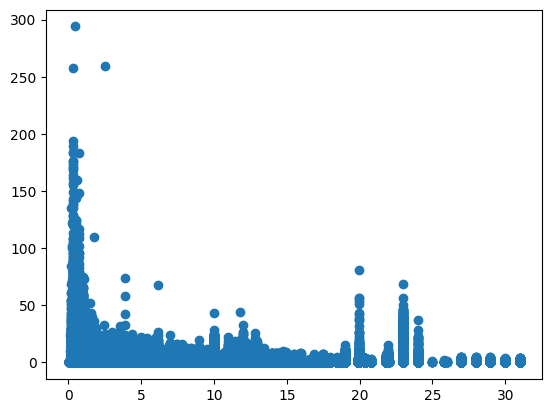

<Figure size 1000x600 with 0 Axes>

In [6]:
# To get a rough idea of relationship between price and quantity
# We can see the distribution of price and quantity
# when price is low, quantity sold is higher
plt.scatter(hobbies_df['sell_price'],hobbies_df['sold'])
plt.figure(figsize=(10, 6))
plt.show()

In [10]:
# Group by 'id' and 'wm_yr_wk', and aggregate 'sold' with sum and 'sell_price' with mean
sum_sold_mean_price = hobbies_df.groupby(['id','item_id', 'dept_id','store_id','state_id','wm_yr_wk']).agg({'sold': 'sum', 'sell_price': 'mean'}).reset_index()

# Sort the DataFrame by 'wm_yr_wk' to ensure consecutive weeks
sum_sold_mean_price.sort_values(by='wm_yr_wk', inplace=True)

# Assign group numbers for every 4 weeks
group_size = 4
sum_sold_mean_price['4_week_group'] = sum_sold_mean_price.groupby(['id','item_id', 'dept_id','store_id','state_id'])['wm_yr_wk'].transform(lambda x: (x.rank(method='dense') - 1) // group_size)

# Group by 'id' and '4_week_group', and aggregate 'sold' with sum and 'sell_price' with mean
hobbies_4_weeks = sum_sold_mean_price.groupby(['id','item_id', 'dept_id','store_id','state_id', '4_week_group']).agg({'sold': 'sum', 'sell_price': 'mean'}).reset_index()

# Rename the columns for clarity
hobbies_4_weeks.columns = ['id','item_id', 'dept_id','store_id','state_id', '4_week_group', 'sold', 'sell_price']

In [21]:
# How each specific food items react to price changes.
# Ex: apple in Mcity.
sum_ped_id_hobbies = hobbies_df.groupby(['id','wm_yr_wk']).agg({'sold': 'sum', 'sell_price': 'mean'}).reset_index()


                                    id  wm_yr_wk  sold  sell_price
0        HOBBIES_1_001_CA_1_validation     11325     1        9.58
1        HOBBIES_1_001_CA_1_validation     11326     0        9.58
2        HOBBIES_1_001_CA_1_validation     11327     2        8.26
3        HOBBIES_1_001_CA_1_validation     11328     2        8.26
4        HOBBIES_1_001_CA_1_validation     11329     6        8.26
...                                ...       ...   ...         ...
1238700  HOBBIES_2_149_WI_3_validation     11609     0        0.97
1238701  HOBBIES_2_149_WI_3_validation     11610     1        0.97
1238702  HOBBIES_2_149_WI_3_validation     11611     1        0.97
1238703  HOBBIES_2_149_WI_3_validation     11612     2        0.97
1238704  HOBBIES_2_149_WI_3_validation     11613     0        0.97

[1238705 rows x 4 columns]


PED of hobbies category:

In [38]:
# How the whole category react to price changes.
# Ex: All hobbies items in the whole Australia.
ped_hobbies = hobbies_df.groupby('cat_id').apply(ped1, include_groups = False)
print(ped_hobbies)

cat_id
HOBBIES   -0.3675
dtype: float64


The Price Elasticity of Demand (PED) for hobby items is -0.3675. This indicates that sales are relatively inelastic, meaning that a 1% increase in price results in approximately a 0.3675% decrease in sales, reflecting a lower sensitivity to price changes

PED of hobbies items by state:

In [29]:
# How all hobbies items in each state react to price changes.
# Ex: Foods (apple,orange,banana...) in Victoria.
ped_state_item_id_hobbies = hobbies_df.groupby('state_id').apply(ped1,include_groups=False)
print(ped_state_item_id_hobbies)

state_id
CA   -0.423506
TX   -0.228639
WI   -0.396050
dtype: float64


These values indicate that sales of hobby items are inelastic in each state, with California and Wisconsin having more elastic demand compared to Texas

PED of hobbies items by store:

In [30]:
# How all foods in each store react to price changes.
# Ex: Foods (apple,orange,banana...) in Mcity.
ped_store_item_id_hobbies = hobbies_df.groupby('store_id').apply(ped1,include_groups=False)
print(ped_store_item_id_hobbies)

store_id
CA_1   -0.388192
CA_2   -0.445331
CA_3   -0.412122
CA_4   -0.468916
TX_1   -0.342390
TX_2   -0.255702
TX_3   -0.106331
WI_1   -0.406485
WI_2   -0.348538
WI_3   -0.418785
dtype: float64


- These values indicate that sales of hobby items are inelastic in each store, with different levels of elasticity among the states. 
- Stores in California and Wisconsin generally show more elastic demand compared to Texas, with Texas stores demonstrating varying degrees of elasticity.

PED of hobbies items by department:

In [39]:
# How different department react to price changes.
# Ex: Foods (apple,orange,banana...) in Mcity.
ped_dept_id_hobbies = hobbies_df.groupby('dept_id').apply(ped1, include_groups = False)
print(ped_dept_id_hobbies)

dept_id
HOBBIES_1   -0.545789
HOBBIES_2   -0.354913
dtype: float64


These values indicate that both departments exhibit inelastic demand, but HOBBIES_1 shows a more elastic demand compared to HOBBIES_2, suggesting greater sensitivity to price changes in the HOBBIES_1 department.

PED heatmap of hobbies items by store and department:

This heatmap depicts the price elasticity of demand for different stores across two departments. Each cell indicates the elasticity value for a specific store and department pair, with warmer colors (red) representing lower elasticity (i.e. less responsive demand to price changes) and cooler colors (blue) indicating higher elasticity (i.e., more responsive demand). The legend to the right shows the range of values allowing for a quick visual comparison between store-department combinations.

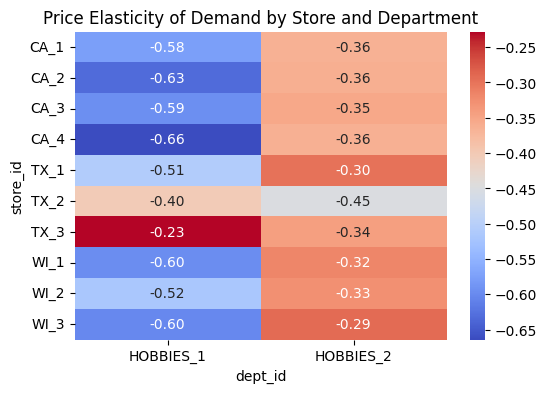

In [51]:
# How different department in different stores react to price changes.
# Ex: Foods (apple,orange,banana...) in Mcity.
ped_store_dept_id_hobbies = hobbies_df.groupby(['store_id','dept_id']).apply(ped1, include_groups = False)
print(ped_store_dept_id_hobbies)
ped_store_dept_id_hobbies = ped_store_dept_id_hobbies.to_frame().reset_index()
ped_store_dept_id_hobbies.columns = ['store_id', 'dept_id', 'PED']

# Creating a heatmap
plt.figure(figsize=(6, 4))
heatmap_data = ped_store_dept_id_hobbies.pivot(index='store_id', columns='dept_id', values='PED')
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", fmt=".2f")
plt.title('Price Elasticity of Demand by Store and Department')
plt.show()

- The chart indicates that the PED varies significantly between stores, the value range from -0.25 to -0.65, an inelastic demand for all stores and department. HOBBIES_1 generally showing higher elasticity compared to HOBBIES_2. This reflects differing sensitivities to price changes across different stores and departments
- CA stores (CA_1, CA_2, CA_3, CA_4) exhibit moderate to high elasticity for HOBBIES_1 (ranging from -0.58 to -0.66) and moderate elasticity for HOBBIES_2 (ranging from -0.35 to -0.36).
- Texas stores display varying levels of elasticity for both departments, with TX_3 having the lowest elasticity (-0.23 for HOBBIES_1 and -0.34 for HOBBIES_2).
- Wisconsin stores show moderate elasticity for both departments, with slight variations (ranging from -0.60 to -0.52 for HOBBIES_1 and from -0.29 to -0.34 for HOBBIES_2).

PED of hobbies items by id:

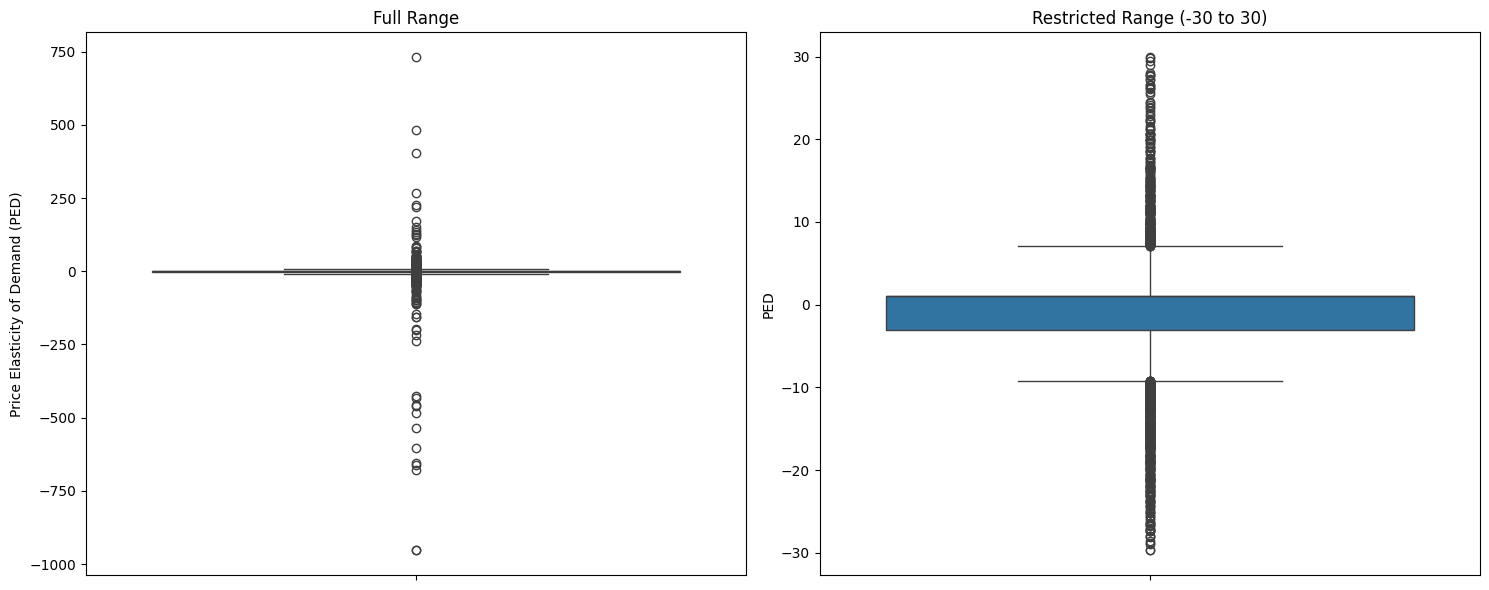

In [25]:
# How each type of food item react to price changes.
# Ex: Apple in the whole Australia.
ped_id_hobbies = hobbies_df.groupby('id').apply(ped1, include_groups = False)
ped_df = ped_id_hobbies.reset_index()
ped_df.columns = ['ID', 'PED']

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Box plot with the full range
sns.boxplot(y=ped_df['PED'], ax=axes[0])
axes[0].set_title('Full Range')
axes[0].set_ylabel('Price Elasticity of Demand (PED)')

# Box plot restricted to a range of -30 to 30
sns.boxplot(y=ped_df[abs(ped_df['PED']) <= 30]['PED'], ax=axes[1])
axes[1].set_title('Restricted Range (-30 to 30)')

# Display the plots
plt.tight_layout()
plt.show()

PED for hobbies items by item id:

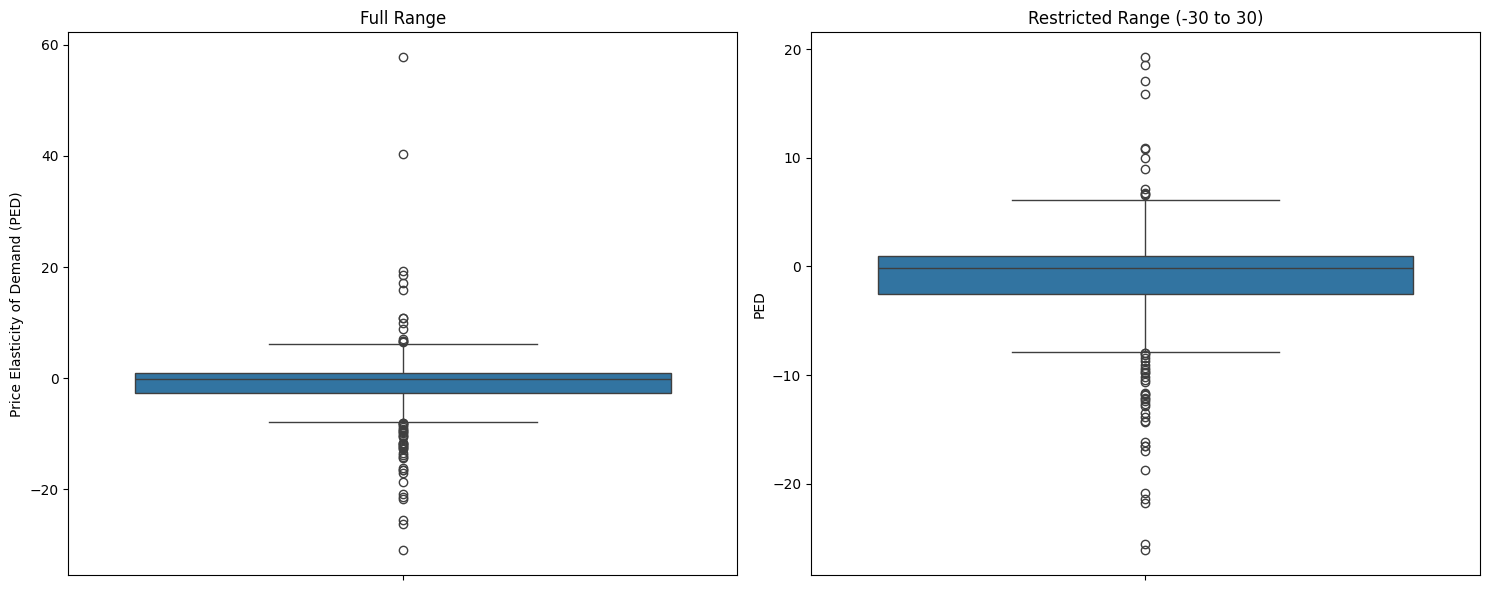

In [24]:
# How each type of food item react to price changes.
# Ex: Apple in the whole Australia.
ped_item_id_hobbies = hobbies_df.groupby('item_id').apply(ped1, include_groups = False)
ped_df = ped_item_id_hobbies.reset_index()
ped_df.columns = ['Item ID', 'PED']

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Box plot with the full range
sns.boxplot(y=ped_df['PED'], ax=axes[0])
axes[0].set_title('Full Range')
axes[0].set_ylabel('Price Elasticity of Demand (PED)')

# Box plot restricted to a range of -30 to 30
sns.boxplot(y=ped_df[abs(ped_df['PED']) <= 30]['PED'], ax=axes[1])
axes[1].set_title('Restricted Range (-30 to 30)')

# Display the plots
plt.tight_layout()
plt.show()

## Analysis of PED for foods items

In [10]:
foods_df = pd.read_csv('foods_df.csv')
foods_df =foods_df.drop(foods_df.columns[0],axis=1)
foods_df = foods_df.dropna(subset = ['sell_price'])

Relationship between item price and sale volume :

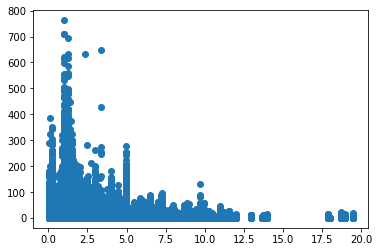

<Figure size 720x432 with 0 Axes>

In [111]:
# We can see the distribution of price and quantity
# when price is low, quantity sold is higher
plt.scatter(foods_df['sell_price'],foods_df['sold'])
plt.figure(figsize=(10, 6))
plt.show()

PED of foods :

In [62]:
# How the whole category react to price changes.
# Ex: All food items in the whole Australia.
ped_foods = foods_df.groupby('cat_id').apply(ped1, include_groups = False)
print(ped_foods)

cat_id
FOODS   -0.595671
dtype: float64


This indicates that the demand for food items is relatively inelastic, meaning that a 1% increase in price leads to approximately a 0.5957% decrease in sales. This suggests that food item sales have a moderate sensitivity to price changes, reflecting consistent demand despite price variations

PED of foods items by state:

In [16]:
# How foods in each state react to price changes.
# Ex: Foods (apple,orange,banana...) in Victoria.
ped_state_item_id_food =foods_df.groupby('state_id').apply(ped1,include_groups=False)
print(ped_state_item_id_food)

state_id
CA   -0.561844
TX   -0.598503
WI   -0.641968
dtype: float64


- California: The PED is -0.5618, indicating that demand for hobby items in California is inelastic. This means that a 1% increase in price leads to an approximate 0.5618% decrease in sales.
- Texas: The PED is -0.5985, also indicating inelastic demand. This suggests that sales decrease by approximately 0.5985% for each 1% increase in price.
- Wisconsin: The PED is -0.6420, further demonstrating inelastic demand. A 1% increase in price results in a roughly 0.6420% decrease in sales.

PED of foods item by store:

In [17]:
# How foods in each store react to price changes.
# Ex: Foods (apple,orange,banana...) in Mcity.
ped_store_item_id_food =foods_df.groupby('store_id').apply(ped1,include_groups=False)
print(ped_store_item_id_food)

store_id
CA_1   -0.574471
CA_2   -0.508451
CA_3   -0.598783
CA_4   -0.510226
TX_1   -0.601425
TX_2   -0.616935
TX_3   -0.574176
WI_1   -0.585910
WI_2   -0.616041
WI_3   -0.711130
dtype: float64


These results indicate that the demand for foods items is generally inelastic across all stores, with Texas and Wisconsin stores showing slightly higher elasticity compared to California stores. The variation among stores reflects the differing sensitivities to price changes, highlighting potential regional differences.

PED of foods items by department:

In [63]:
# How the whole category react to price changes.
# Ex: All food items in the whole Australia.
ped_dept_id_foods = foods_df.groupby('dept_id').apply(ped1, include_groups = False)
print(ped_dept_id_foods)

dept_id
FOODS_1   -0.638390
FOODS_2   -0.481386
FOODS_3   -0.594738
dtype: float64


These values show that the demand for food items is inelastic across all departments. This suggests that sales for food items are relatively insensitive to price changes, with a 1% increase in price leading to approximately a 0.48% to 0.64% decrease in sales, depending on the department.

Heatmap for PED of foods items by store and department:

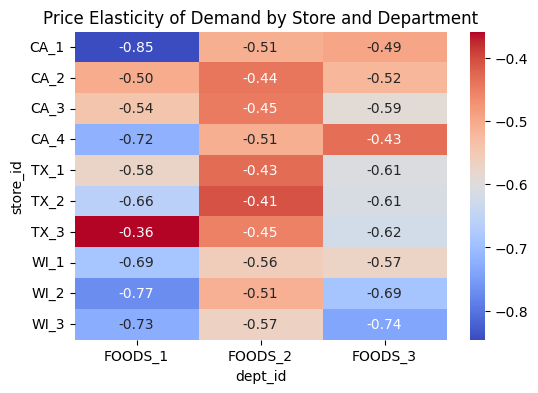

In [67]:
# How foods in each state react to price changes.
# Ex: Foods (apple,orange,banana...) in Victoria.
ped_store_dept_id_foods =foods_df.groupby(['store_id','dept_id']).apply(ped1,include_groups=False)
ped_store_dept_id_foods = ped_store_dept_id_foods.to_frame().reset_index()
# Creating a heatmap
ped_store_dept_id_foods.columns = ['store_id', 'dept_id', 'PED']
plt.figure(figsize=(6, 4))
heatmap_data = ped_store_dept_id_foods.pivot(index='store_id', columns='dept_id', values='PED')
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", fmt=".2f")
plt.title('Price Elasticity of Demand by Store and Department')
plt.show()

- In general, department 2 generally has lower PED values compared to other departments, indicating slightly less inelastic demand for its food items. FOODS_1 in WI stores have lower inelasticity compared to FOODS_1 in CA and TX. FOOD_3 in CA stores have higher inelasticities compared to TX and WI.
- For stores in CA, CA_1 exhibit a lower inelastic demand for FOODS_1 (-0.85), moderate inelasticity for FOODS_2 (-0.51), and slightly higher inelasticity for FOODS_3 (-0.49). For the rest of the stores, it displays varying degrees of inelasticity across all departments, with CA_4 having lowest inelasticity for FOODS_1 (-0.72).
- There are also varying levels of inelasticity across all departments in stores of TX, with FOODS_3 having relatively lower inelasticity (-0.61) and FOODS_2 having relatively higher inelasticity (-0.41 ~ -0.45).
- Similar to texas stores, FOODS_2 in stores of WI having higher inelasticity compared to FOODS_1 (-0.69 ~ -0.77) and FOODS_3 (-0.57 ~ -0.74).

PED of foods items by id:

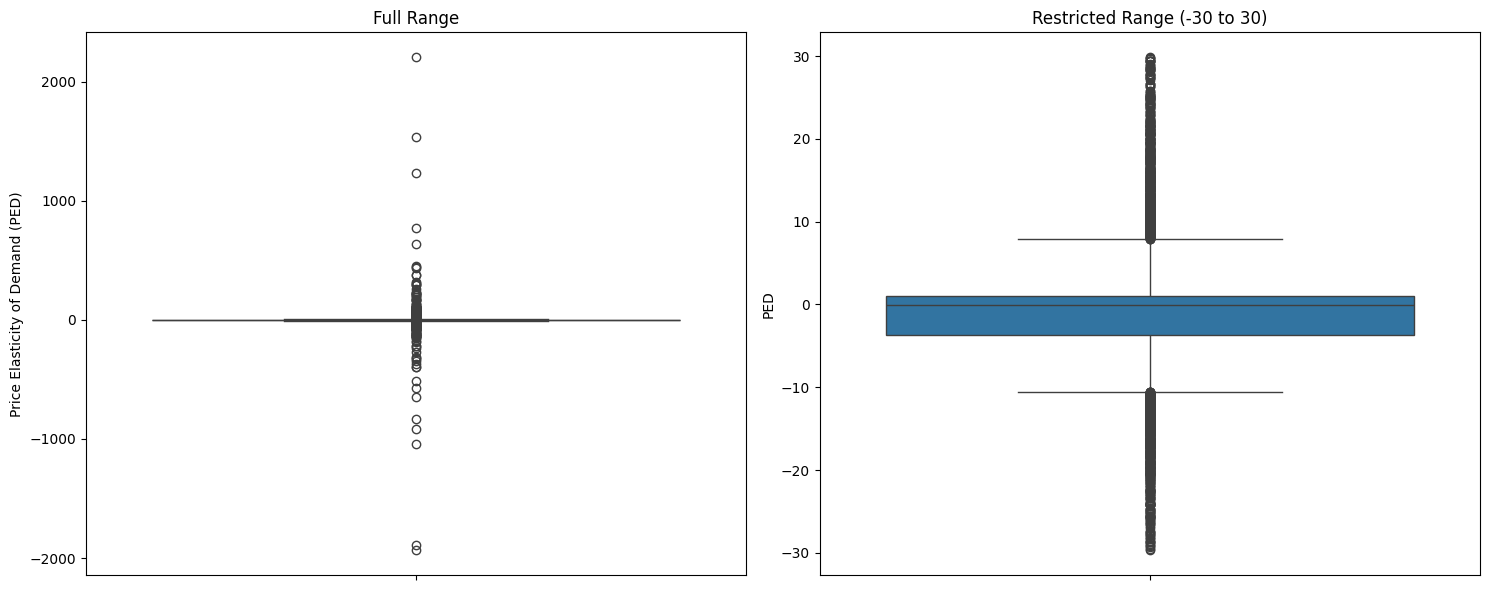

In [19]:
# How each specific food items react to price changes.
# Ex: apple in Mcity.
ped_id_foods =foods_df.groupby('id').apply(ped1, include_groups =False)
ped_id_foods = ped_id_foods.to_frame().reset_index()

# Rename the columns for clarity
ped_id_foods.columns = ['ID', 'PED']
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Full range box plot
sns.boxplot(y=ped_id_foods['PED'], ax=axes[0])
axes[0].set_title('Full Range')
axes[0].set_ylabel('Price Elasticity of Demand (PED)')

# Filtered DataFrame for -30 to 30 range
ped_filtered = ped_id_foods[(ped_id_foods['PED'] >= -30) & (ped_id_foods['PED'] <= 30)]

# Restricted range box plot
sns.boxplot(y=ped_filtered['PED'], ax=axes[1])
axes[1].set_title('Restricted Range (-30 to 30)')

# Display the plots
plt.tight_layout()
plt.show()

PED of foods items by item id:

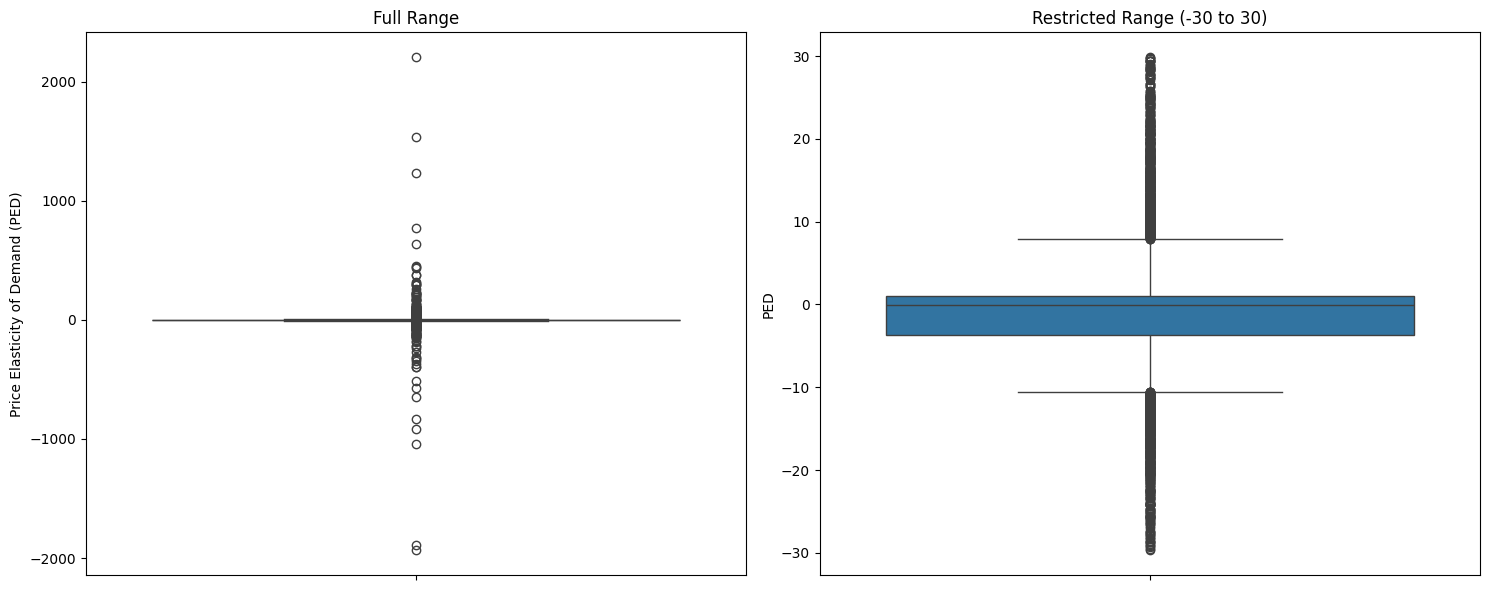

In [20]:
# How each type of food item react to price changes.
# Ex: Apple in the whole Australia.
ped_item_id_food = foods_df.groupby('item_id').apply(ped1, include_groups =False)
ped_item_id_food = ped_item_id_food.to_frame().reset_index()

# Rename the columns for clarity
ped_id_foods.columns = ['Item ID', 'PED']
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Full range box plot
sns.boxplot(y=ped_id_foods['PED'], ax=axes[0])
axes[0].set_title('Full Range')
axes[0].set_ylabel('Price Elasticity of Demand (PED)')

# Filtered DataFrame for -30 to 30 range
ped_filtered = ped_id_foods[(ped_id_foods['PED'] >= -30) & (ped_id_foods['PED'] <= 30)]

# Restricted range box plot
sns.boxplot(y=ped_filtered['PED'], ax=axes[1])
axes[1].set_title('Restricted Range (-30 to 30)')

# Display the plots
plt.tight_layout()
plt.show()

## Analysis of PED for households items

In [21]:
households_df = pd.read_csv('households_df.csv')
households_df = households_df.drop(households_df.columns[0],axis=1)
households_df = households_df.dropna(subset = ['sell_price'])

Relationship between item price & sales volume:

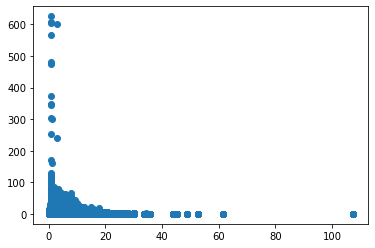

<Figure size 720x432 with 0 Axes>

In [187]:
# We can see the distribution of price and quantity
# when price is low, quantity sold is higher
plt.scatter(households_df['sell_price'],households_df['sold'])
plt.figure(figsize=(10, 6))
plt.show()

PED of households items by state:

In [192]:
# How foods in each state react to price changes.
# Ex: Foods (apple,orange,banana...) in Victoria.
ped_state_item_id_households = households_df.groupby('state_id').apply(ped1, include_groups =False)
print(ped_state_item_id_households)

state_id
CA   -0.672693
TX   -0.835770
WI   -0.861048
dtype: float64


- All three states exhibit inelastic demand for items, indicating that changes in price have a relatively smaller effect on the quantity demanded.
- Among the three states, Wisconsin (WI) has the lowest inelasticity of demand, indicating that price changes have the most effect on sales in this state.
- Texas (TX) follows with a slightly lower inelasticity, while California (CA) has the highest inelasticity among the three states, suggesting a relatively lower sensitivity to price changes compared to Texas and Wisconsin.

PED of households item by store:

In [193]:
# How foods in each store react to price changes.
# Ex: Foods (apple,orange,banana...) in Mcity.
ped_store_item_id_households = households_df.groupby('store_id').apply(ped1, include_groups =False)
print(ped_store_item_id_households)

store_id
CA_1   -0.639014
CA_2   -0.577400
CA_3   -0.770494
CA_4   -0.576431
TX_1   -0.859197
TX_2   -0.786838
TX_3   -0.866839
WI_1   -0.755076
WI_2   -0.958233
WI_3   -0.835668
dtype: float64


- All stores across CA, TX, and WI exhibit inelastic demand for items, indicating that changes in price have a relatively smaller effect on the quantity demanded.
- Among all the stores, CA_2 and CA_4 have the highest inelasticity, indicating that price changes have a least effect on sales in these stores.
- Generally, stores in CA have slightly lower inelasticity compared to stores in TX and WI, suggesting a potentially lower sensitivity to price changes in this region.

PED of households items by department:

In [194]:
# How foods in each dept react to price changes.
# Ex: Foods (apple,orange,banana...) in all dept 1,2,3 including all woolies in Aus.
ped_dept_item_id_households = households_df.groupby('dept_id').apply(ped1, include_groups =False)
print(ped_dept_item_id_households)

dept_id
HOUSEHOLD_1   -0.567125
HOUSEHOLD_2   -0.575657
dtype: float64


Both departments exhibit inelastic demand for household items, this suggests that demand for household items is relatively insensitive to price changes in both departments in general.

PED Heatmap of households items by store and department:

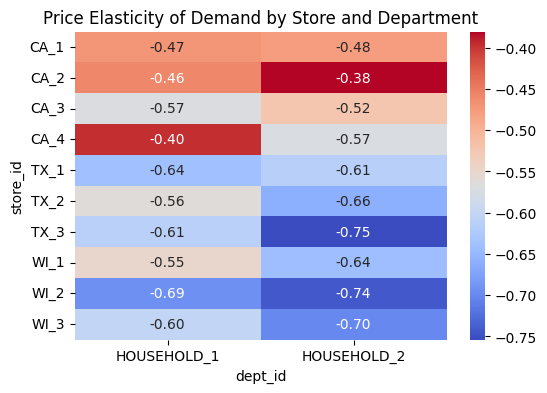

In [78]:
# How foods in each state react to price changes.
# Ex: Foods (apple,orange,banana...) in Victoria.
ped_store_dept_id_households = households_df.groupby(['store_id','dept_id']).apply(ped1,include_groups=False)
ped_store_dept_id_households = ped_store_dept_id_households.to_frame().reset_index()

# Creating a heatmap
ped_store_dept_id_households.columns = ['store_id', 'dept_id', 'PED']
plt.figure(figsize=(6, 4))
heatmap_data = ped_store_dept_id_households.pivot(index='store_id', columns='dept_id', values='PED')
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", fmt=".2f")
plt.title('Price Elasticity of Demand by Store and Department')
plt.show()

- All stores and departments have inelastic demand. The values range from around -0.75 to -0.38. In general, HOUSEHOLD_2 shows lower inelasticities compared to HOUSEHOLD_1, stores in CA has a higher inelasticity in demand compared to stores in other states.
- Stores in CA has show high inelasticity for both departments, while CA_4 and CA_2 has highest inelastic demand for HOUSEHOLD_1 and  HOUSEHOLD_2 respectively among all stores.
- Stores in TX show more elastic demand in second departments, indicating customers are more price-sensitive for items in this department.
- Varying elasticity is observed across the stores in WI, with WI_2 showing the highest elasticity for both departments.

PED of households items by id:

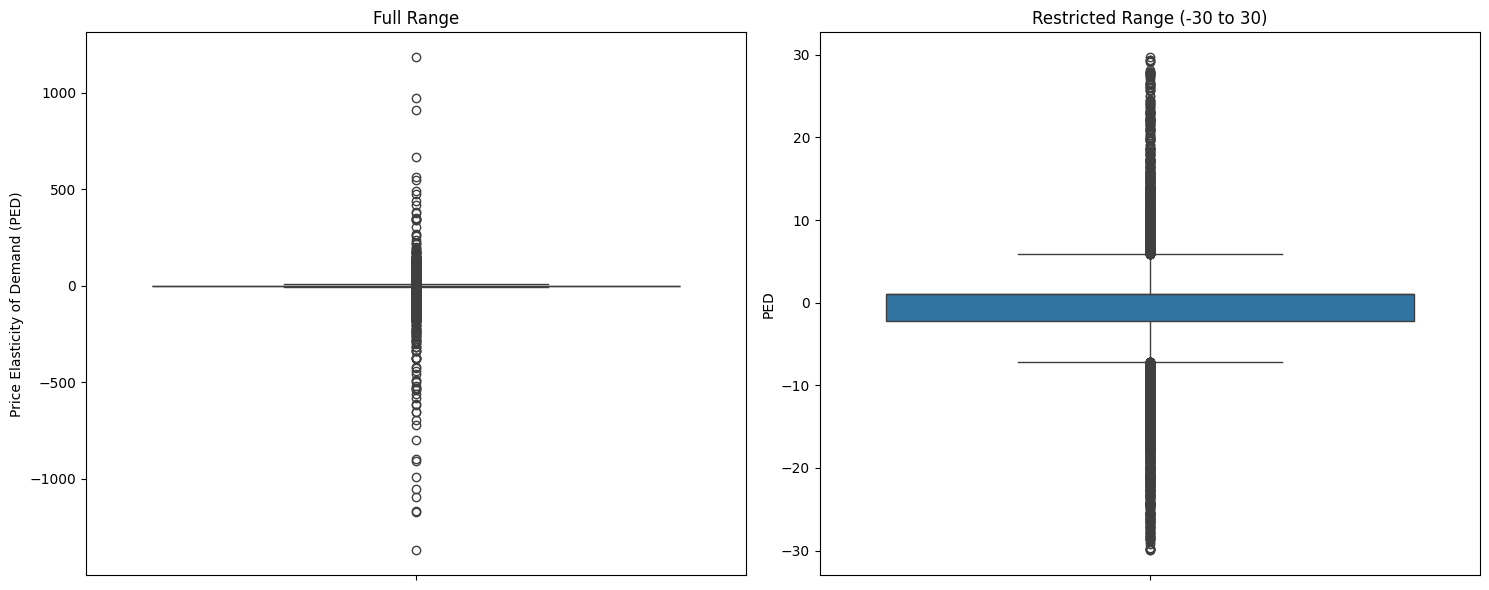

In [23]:
# How each type of food item react to price changes.
# Ex: Apple in the whole Australia.
ped_id_households = households_df.groupby('id').apply(ped1, include_groups =False)
ped_id_households = ped_id_households.to_frame().reset_index()

# Rename the columns for clarity
ped_id_households.columns = ['ID', 'PED']
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Full range box plot
sns.boxplot(y=ped_id_households['PED'], ax=axes[0])
axes[0].set_title('Full Range')
axes[0].set_ylabel('Price Elasticity of Demand (PED)')

# Filtered DataFrame for -30 to 30 range
ped_filtered = ped_id_households[(ped_id_households['PED'] >= -30) & (ped_id_households['PED'] <= 30)]

# Restricted range box plot
sns.boxplot(y=ped_filtered['PED'], ax=axes[1])
axes[1].set_title('Restricted Range (-30 to 30)')

# Display the plots
plt.tight_layout()
plt.show()

PED of households items by item id:

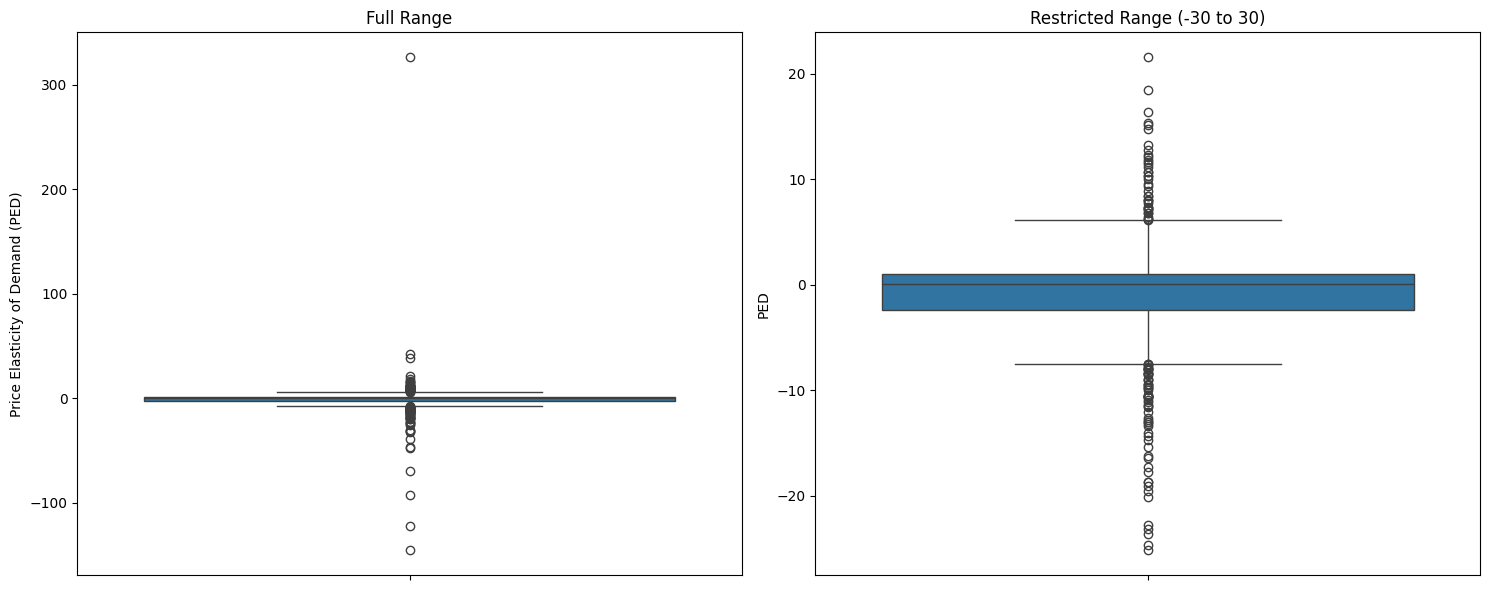

In [22]:
# How each type of food item react to price changes.
# Ex: Apple in the whole Australia.
ped_id_households = households_df.groupby('item_id').apply(ped1, include_groups =False)
ped_id_households = ped_id_households.to_frame().reset_index()

# Rename the columns for clarity
ped_id_households.columns = ['Item ID', 'PED']
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Full range box plot
sns.boxplot(y=ped_id_households['PED'], ax=axes[0])
axes[0].set_title('Full Range')
axes[0].set_ylabel('Price Elasticity of Demand (PED)')

# Filtered DataFrame for -30 to 30 range
ped_filtered = ped_id_households[(ped_id_households['PED'] >= -30) & (ped_id_households['PED'] <= 30)]

# Restricted range box plot
sns.boxplot(y=ped_filtered['PED'], ax=axes[1])
axes[1].set_title('Restricted Range (-30 to 30)')

# Display the plots
plt.tight_layout()
plt.show()